#Gender Classification API using Machine Learning

In [1]:
!pip install --upgrade pip
!pip install transformers datasets evaluate seqeval accelerate huggingface_hub gradio
!pip install -U transformers accelerate datasets evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16250 sha256=b34e460823f69808dec1d274c36b065b7769fbf6a482b93262f8f523840508a0
  Stored in directory: /root/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seqeval
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [evaluate]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 41.3 MB/s  0:00:01
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall

In [8]:
# ================================
# 🚀 GENDER CLASSIFICATION MODEL (BERT)
# ================================
# Compatible with: Transformers 4.40.1+
# Dataset columns: code, company, name, gender, age
# ================================================
!pip install --upgrade transformers


import os
import json
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import evaluate
import torch

# ======= CONFIG =======
DATA_PATH = "/content/users.csv"  # Update path if needed
MODEL_NAME = "bert-base-uncased"  # ✅ Switched from DistilBERT to BERT
OUTPUT_DIR = "model_gender"
BATCH_SIZE = 8
EPOCHS = 3
MAX_LEN = 32
SEED = 42
# =======================

# ✅ Load dataset
df = pd.read_csv(DATA_PATH)
print("✅ Loaded dataset with columns:", df.columns.tolist())

# ✅ Prepare text & labels
df = df.rename(columns={"name": "text", "gender": "label"})
df = df[["text", "label"]].dropna()
df["text"] = df["text"].astype(str).str.strip()
df["label"] = df["label"].astype(str).str.strip().str.capitalize()

# ✅ Encode label values
label_list = sorted(df["label"].unique())
label2id = {v: i for i, v in enumerate(label_list)}
id2label = {i: v for v, i in label2id.items()}
df["label_id"] = df["label"].map(label2id)
print("✅ Label mapping:", label2id)

# ✅ Train/test split
train_df = df.sample(frac=0.8, random_state=SEED)
test_df = df.drop(train_df.index)

# Keep only text + numeric labels to avoid duplicates
train_df = train_df[["text", "label_id"]].rename(columns={"label_id": "label"})
test_df = test_df[["text", "label_id"]].rename(columns={"label_id": "label"})

# ✅ Convert to Hugging Face Datasets
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

# ✅ Tokenization
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def preprocess(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=MAX_LEN)

train_ds = train_ds.map(preprocess, batched=True)
test_ds = test_ds.map(preprocess, batched=True)
train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# ✅ Load BERT model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

# ✅ Define evaluation metrics
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "precision": precision.compute(predictions=preds, references=labels, average="macro")["precision"],
        "recall": recall.compute(predictions=preds, references=labels, average="macro")["recall"],
        "f1": f1.compute(predictions=preds, references=labels, average="macro")["f1"],
    }

# ✅ Training arguments (W&B disabled)
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none",
    save_strategy="epoch",
    logging_steps=50,
    seed=SEED,
)


# ✅ Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# ✅ Train + Evaluate
trainer.train()
metrics = trainer.evaluate()

print("\n🎯 Final Evaluation Metrics:")
for k, v in metrics.items():
    if isinstance(v, (float, int)):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}")

# ✅ Save model + tokenizer + mapping
os.makedirs(OUTPUT_DIR, exist_ok=True)
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
with open(f"{OUTPUT_DIR}/label_mapping.json", "w") as f:
    json.dump({"label2id": label2id, "id2label": id2label}, f)

print(f"\n✅ Model saved successfully in: {OUTPUT_DIR}")


✅ Loaded dataset with columns: ['code', 'company', 'name', 'gender', 'age']
✅ Label mapping: {'Female': 0, 'Male': 1, 'None': 2}


Map:   0%|          | 0/1072 [00:00<?, ? examples/s]

Map:   0%|          | 0/268 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1484623329.py:115: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,1.003500
100,0.750200
150,0.697500
200,0.670200
250,0.652500
300,0.687000
350,0.651200
400,0.617900


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



🎯 Final Evaluation Metrics:
eval_loss: 0.7639
eval_accuracy: 0.6231
eval_precision: 0.4192
eval_recall: 0.6399
eval_f1: 0.5063
eval_runtime: 20.4707
eval_samples_per_second: 13.0920
eval_steps_per_second: 1.6610
epoch: 3.0000

✅ Model saved successfully in: model_gender


In [9]:
!pip install -q gradio pyngrok transformers torch


In [12]:
%%writefile app_ngrok.py
import gradio as gr
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from pyngrok import ngrok
import json
import threading

MODEL_DIR = "/content/model_gender"

print("✅ Loading tokenizer and model...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
model.eval()

# Load label mapping
with open(f"{MODEL_DIR}/label_mapping.json", "r") as f:
    label_map = json.load(f)
id2label = {int(k): v for k, v in label_map["id2label"].items()}
print("✅ Model labels:", id2label)

# Prediction function
def predict_gender(name):
    if not name.strip():
        return {"Error": "Please enter a valid name."}
    inputs = tokenizer(name, return_tensors="pt", truncation=True, padding=True, max_length=32)
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = torch.softmax(logits, dim=-1).numpy()[0]
    pred_id = int(probs.argmax())
    pred_label = id2label[pred_id]
    confidence = round(probs[pred_id]*100, 2)
    return {pred_label: confidence}

# Gradio interface
demo = gr.Interface(
    fn=predict_gender,
    inputs=gr.Textbox(label="Enter Name"),
    outputs=gr.Label(label="Predicted Gender"),
    title="🧠 BERT Gender Classifier",
    description="Predicts gender from a name using fine-tuned BERT (educational demo).",
    examples=[["Arjun"], ["Priya"], ["Ravi"], ["Sneha"], ["Karan"]],
)

# Run Gradio app and expose via ngrok
def start_app():
    ngrok.set_auth_token("35Bl3WXYj1SfQCdD1DcaFF6IEEx_3otZ2ZJVmqGWEYyaUuDVo")
    public_url = ngrok.connect(7860)
    print(f"\n🌐 Public URL: {public_url.public_url}")
    demo.launch(server_name="0.0.0.0", server_port=7860, share=False)

threading.Thread(target=start_app).start()


Overwriting app_ngrok.py


In [14]:
!python app_ngrok.py


✅ Loading tokenizer and model...
2025-11-08 21:27:07.458904: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762637227.489039   17078 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762637227.497932   17078 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762637227.522711   17078 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762637227.522792   17078 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762637227.522803   17078 computation_plac

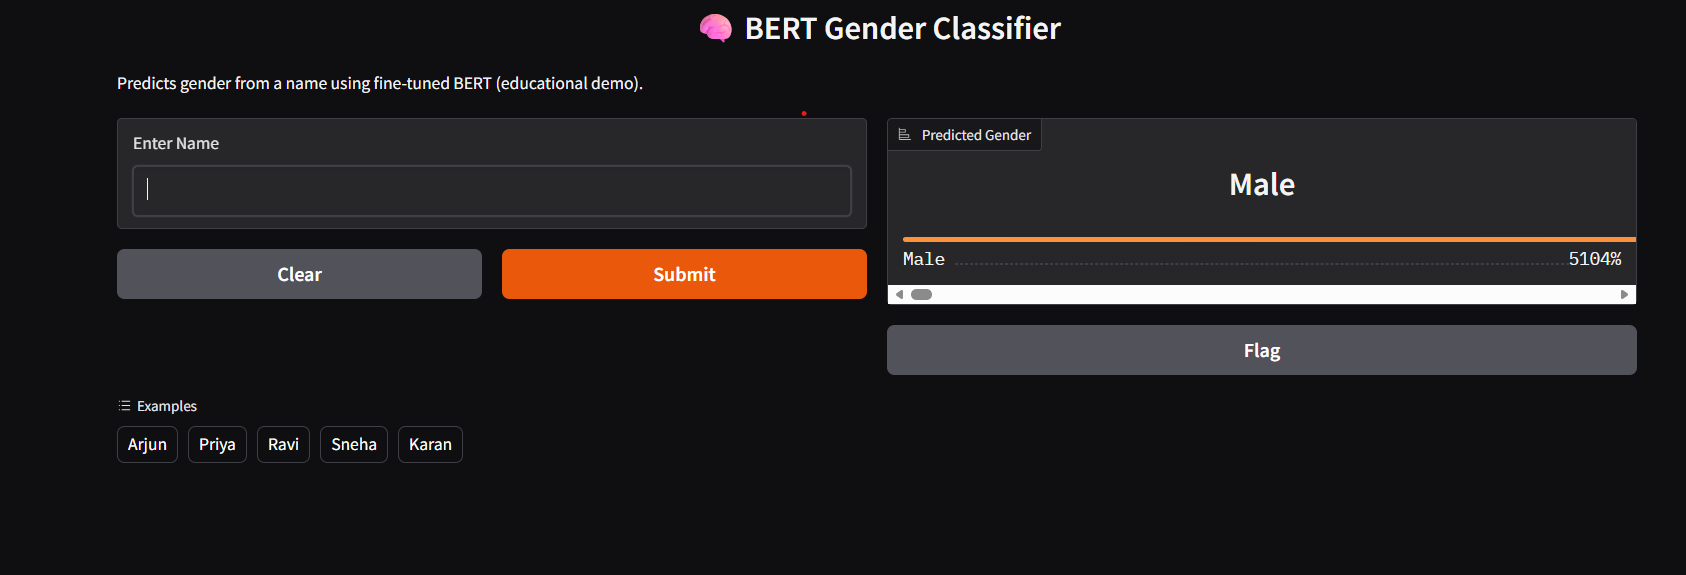